In [180]:
from pathlib import Path
import requests
import matplotlib.pyplot as plt

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

from matplotlib import pyplot
import numpy as np
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

from torch.utils.data import DataLoader,TensorDataset

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_valid, y_valid)
val_dl = DataLoader(val_ds, batch_size=10000, shuffle=False)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)


In [178]:
import torch.nn.functional as F
from torch import nn, optim

dev = torch.device(
    "mps") if torch.backends.mps.is_available() else torch.device("cpu")

class Mnist_linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 784),
            nn.ReLU(),
            nn.Linear(784, 784),
            nn.ReLU(),
            nn.Linear(784, 10))

    def forward(self, xb):
        return self.model(xb)

loss_func = F.cross_entropy

def create_model_and_optim(lr=0.5):
    model = Mnist_linear()
    model.to(dev)
    return model, optim.SGD(model.parameters(), lr=lr)


def train(model,opt,epochs=10):
    accuracy_vals = []
    loss_vals = []
    print("-"*30)
    print(f"Training model: {model.__class__.__name__}")
    print(f"Optimizer: {opt.__class__.__name__}")
    print()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(dev), yb.to(dev)
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in val_dl:
                xb, yb = xb.to(dev), yb.to(dev)
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += (pred.argmax(dim=1) == yb).float().mean()
            nv = len(val_dl)
            print(f"Epoch: {epoch}")
            print(f"Loss: {tot_loss/nv:.4f} Accuracy: {tot_acc/nv*100:.1f}%")
            print()
            loss_vals.append((tot_loss/nv).to("cpu").item())
            accuracy_vals.append((tot_acc/nv*100).to("cpu").item())
    return loss_vals, accuracy_vals

def plot_loss_and_accuracy(loss_val, accuracy_vals):
    plt.plot(loss_val, label="Loss", color="red", linestyle="dashed", marker="o")
    plt.legend()
    # Add title to x axis
    plt.xlabel("Epochs")
    # Add title to y axis
    plt.ylabel("Loss")
    # Add title to graph
    plt.title("Loss vs Epochs")
    # Only show integer epochs 
    # Set y-axis to start at 0
    plt.ylim(0)

    # Plot accuracy in a seperate plot 
    plt.figure()
    # Plot

    plt.plot(accuracy_vals, label="Accuracy", color="green", linestyle="dashed", marker="o")
    # Format accuracy
    plt.yticks(np.arange(0, 100, 10.0));
    plt.legend()
    # Add title to x axis
    plt.xlabel("Epochs")
    # Add title to y axis
    plt.ylabel("Accuracy (%)")
    # Add title to graph
    plt.title("Accuracy vs Epochs")

model,opt = create_model_and_optim(lr = .5)
loss_val, accuracy_vals = train(model,opt,500)    

------------------------------
Training model: Mnist_linear
Optimizer: SGD

Epoch: 0
Loss: 0.3669 Accuracy: 89.7%

Epoch: 1
Loss: 0.2450 Accuracy: 92.7%

Epoch: 2
Loss: 0.2006 Accuracy: 94.3%

Epoch: 3
Loss: 0.1587 Accuracy: 95.5%

Epoch: 4
Loss: 0.1437 Accuracy: 95.9%

Epoch: 5
Loss: 0.1299 Accuracy: 96.4%

Epoch: 6
Loss: 0.1195 Accuracy: 96.7%

Epoch: 7
Loss: 0.1097 Accuracy: 96.9%

Epoch: 8
Loss: 0.1071 Accuracy: 96.9%

Epoch: 9
Loss: 0.0978 Accuracy: 97.2%

Epoch: 10
Loss: 0.0931 Accuracy: 97.4%

Epoch: 11
Loss: 0.0927 Accuracy: 97.3%

Epoch: 12
Loss: 0.0877 Accuracy: 97.2%

Epoch: 13
Loss: 0.0813 Accuracy: 97.6%

Epoch: 14
Loss: 0.0807 Accuracy: 97.6%

Epoch: 15
Loss: 0.0858 Accuracy: 97.4%

Epoch: 16
Loss: 0.0761 Accuracy: 97.8%

Epoch: 17
Loss: 0.0724 Accuracy: 97.9%

Epoch: 18
Loss: 0.0756 Accuracy: 97.9%

Epoch: 19
Loss: 0.0728 Accuracy: 97.8%

Epoch: 20
Loss: 0.0707 Accuracy: 97.9%

Epoch: 21
Loss: 0.0720 Accuracy: 97.8%

Epoch: 22
Loss: 0.0690 Accuracy: 98.0%

Epoch: 23
Loss

In [187]:
# CNN
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
model = Mnist_CNN().to(dev)
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

#CNN Dataloader
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_valid, y_valid)
val_dl = DataLoader(val_ds, batch_size=10000, shuffle=False)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)


loss_val, accuracy_vals = train(model,opt,100)    

------------------------------
Training model: Mnist_CNN
Optimizer: SGD

Epoch: 0
Loss: 0.3360 Accuracy: 89.6%

Epoch: 1
Loss: 0.2193 Accuracy: 93.6%

Epoch: 2
Loss: 0.1992 Accuracy: 94.1%

Epoch: 3
Loss: 0.1921 Accuracy: 94.4%

Epoch: 4
Loss: 0.1604 Accuracy: 95.2%

Epoch: 5
Loss: 0.1433 Accuracy: 96.0%

Epoch: 6
Loss: 0.1332 Accuracy: 96.2%

Epoch: 7
Loss: 0.1515 Accuracy: 95.6%

Epoch: 8
Loss: 0.1614 Accuracy: 95.3%

Epoch: 9
Loss: 0.1284 Accuracy: 96.3%

Epoch: 10
Loss: 0.1312 Accuracy: 96.3%

Epoch: 11
Loss: 0.1257 Accuracy: 96.5%

Epoch: 12
Loss: 0.1210 Accuracy: 96.6%

Epoch: 13
Loss: 0.1309 Accuracy: 96.5%

Epoch: 14
Loss: 0.1360 Accuracy: 96.2%

Epoch: 15
Loss: 0.1219 Accuracy: 96.6%

Epoch: 16
Loss: 0.1171 Accuracy: 96.7%

Epoch: 17
Loss: 0.1270 Accuracy: 96.5%

Epoch: 18
Loss: 0.1178 Accuracy: 96.6%

Epoch: 19
Loss: 0.1239 Accuracy: 96.6%

Epoch: 20
Loss: 0.1247 Accuracy: 96.5%

Epoch: 21
Loss: 0.1156 Accuracy: 96.7%

Epoch: 22
Loss: 0.1163 Accuracy: 96.7%

Epoch: 23
Loss: 0

In [186]:
print(model)



Mnist_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)


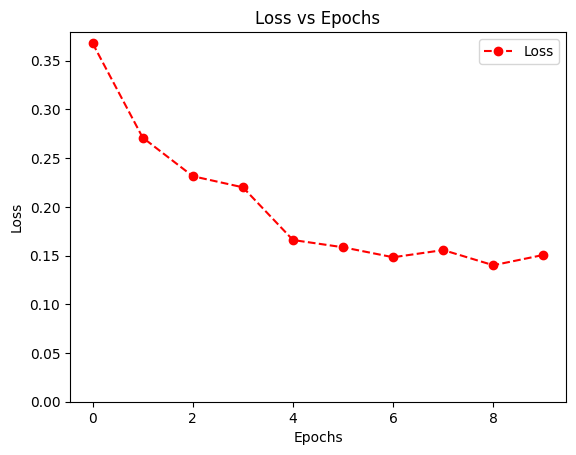

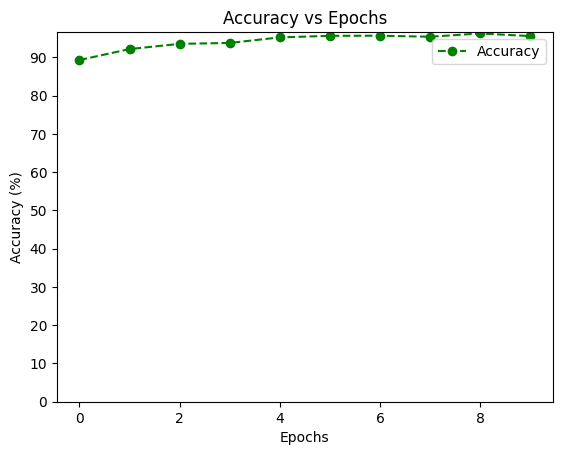

In [185]:
plot_loss_and_accuracy(loss_val, accuracy_vals)